## 📘 Summary of the Lesson

- Built a complete **Diffusers pipeline** manually using:
    - **VAE**, **UNet**, **scheduler**, and **tokenizer**
    - Enables **full customization** of the inference process
- Discussed **three new research papers** released recently:
    - Improve **inference performance by over 10x**
    - Enable editing any photo by simply **describing the desired changes**
- In the second half, Jeremy starts a **“from scratch” Stable Diffusion** implementation:
    - Introduces the **“miniai” library**, developed by students in the course
    - Focuses on **organizing and simplifying code**
- Covers key foundational topics:
    - **Python data model**
    - **Tensors**
    - **Random number generation**
- Introduces and compares:
    - **Wickman-Hill random number generator**
    - **Custom vs PyTorch’s built-in random generators**
- Concludes with:
    - Creating a **linear classifier using tensors**


## **Part 1**
- Papers:
    - Progressive Distillation for Fast Sampling of Diffusion Models
 
    - **Knowledge Distillation** is a technique where a **smaller, faster model** (called the **student**) learns to mimic a **larger, more powerful model** (called the **teacher**).
 
    - **In short: "Big model teaches small model how to perform well."**
 
    - On Distillation of Guided Diffusion Models
        - **This is used to train a faster diffusion model that can sample in fewer steps than the original model — e.g., distilling a 1000-step model into a 4-step model.** 
        - Progressive Distillation accelerates diffusion model sampling effectively by transforming a complex teacher model into a simpler, faster student model.
        - The technique enables high-quality image generation using significantly fewer sampling steps.
        - Progressive Distillation leverages teacher-student training to enhance model efficiency without compromising output quality.
        - The algorithm minimizes noise in predictions by matching outputs instead of averaging multiple inputs, leading to sharper images.
        -  In the distillation process, the teacher model serves as a knowledgeable guide to the student model, where the student learns to replicate the teacher’s output in fewer steps. This relationship enhances the student model’s learning experience and performance.
    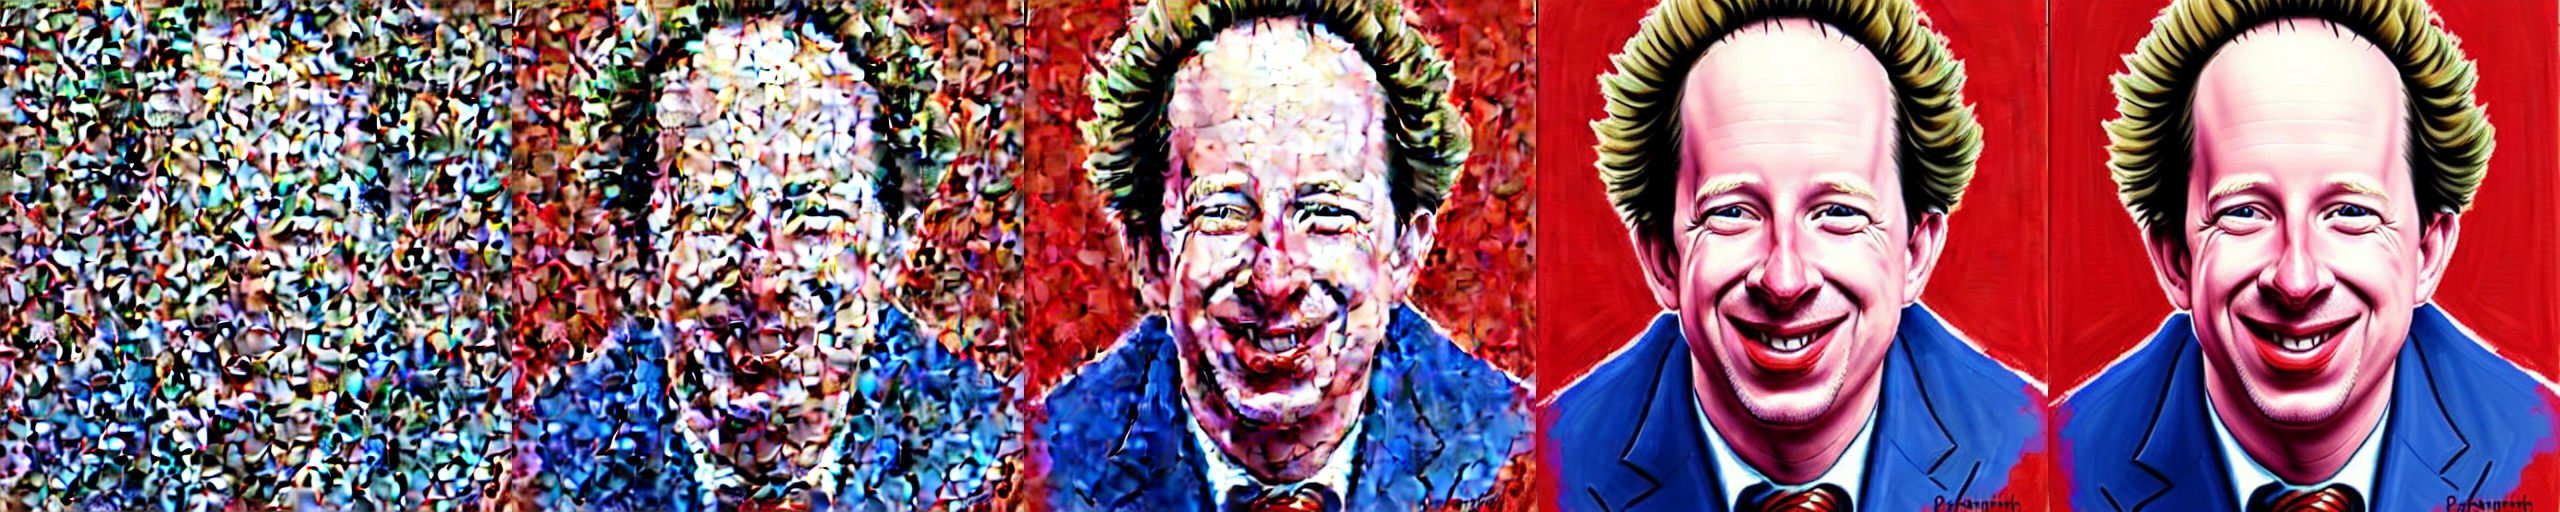
    - Imagic    
        - Image Inversion: Embeds a real image into the latent space of the diffusion model.(Encoder)
        - Prompt Tuning: Adjusts the text embedding to align with the image.
        - Model Fine-Tuning: Fine-tunes the entire diffusion model using the target prompt and embedded image.

    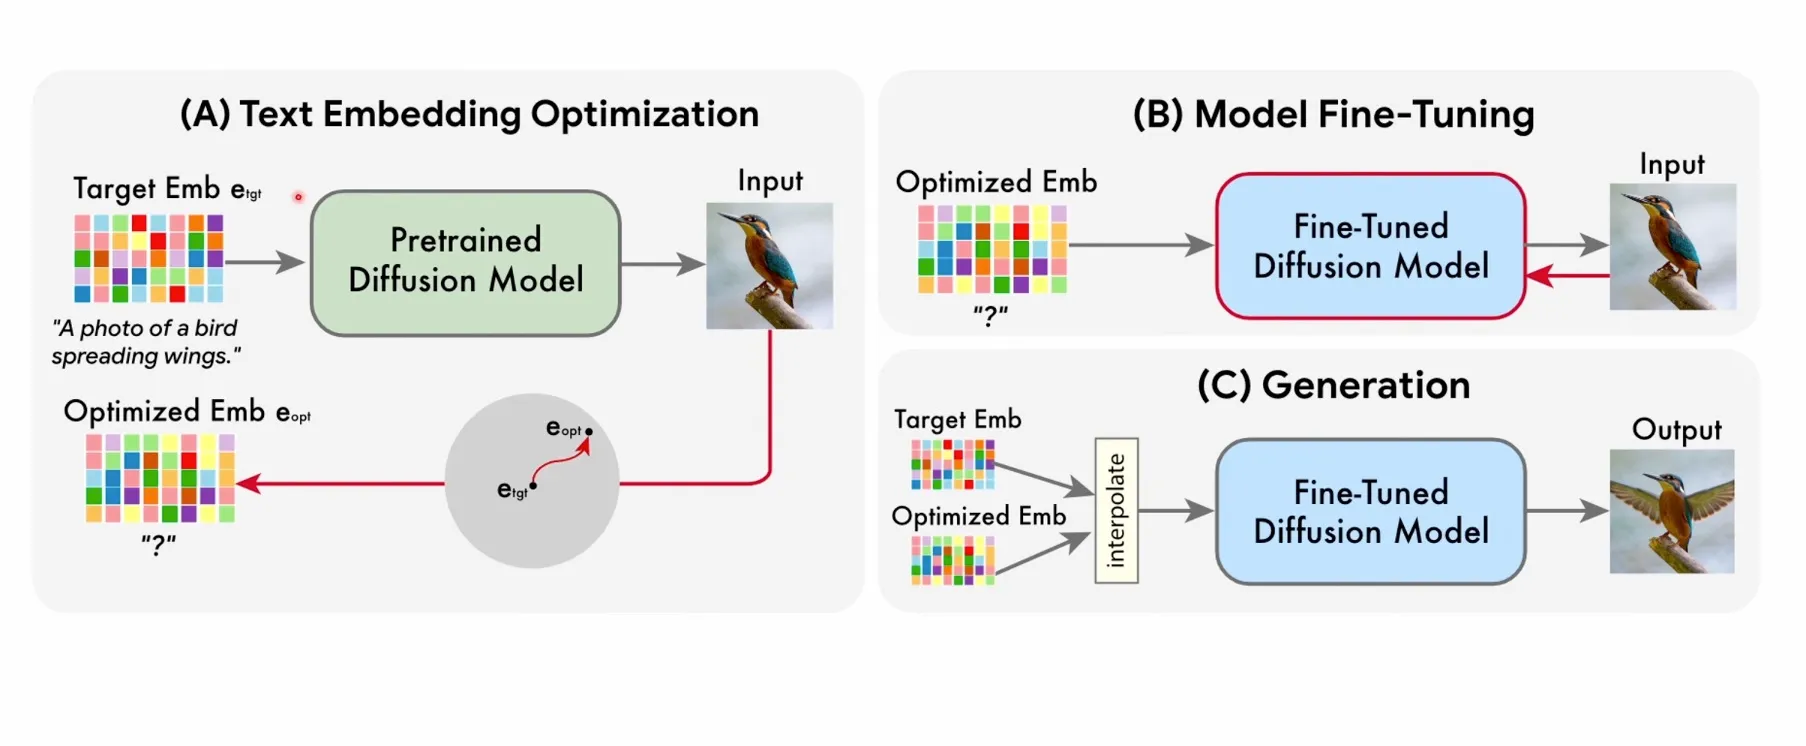
    - Expmaple:
      - Input image: a photo of a dog
      - Text prompt: “A dog wearing sunglasses”
      - → After Imagic: the same dog, but now wearing sunglasses — consistent identity, pose, and background.

## **Part 2**
- Tokenizing input text
- CLIP encoder for embeddings
- Scheduler for noise determination
- Organizing and simplifying code
- Negative prompts and callbacks

jupyter notebook: https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb

### Stable Diffusion & Latent Diffusion
- Stable Diffusion is based on a special kind of diffusion model called Latent Diffusion, introduced in the paper High-Resolution Image Synthesis with Latent Diffusion Models.
- General diffusion models are trained to denoise Gaussian noise step-by-step to generate samples like images.
- A major drawback is that denoising is slow and memory-intensive, especially for high-resolution images, since they operate in pixel space.
- Latent Diffusion improves efficiency by performing the denoising process in a lower-dimensional latent space, not in the pixel space.
- In Latent Diffusion, the model learns to generate compressed (latent) representations of images, reducing memory and compute requirements.
- The Stable Diffusion pipeline allows us to observe intermediate latents during sampling using a callback function.
- These latents can be decoded with the VAE decoder to visualize how the image gradually emerges during the denoising process.


There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

A **scheduler** in diffusion models decides:

- **How to go from noisy to clean**
- **How big the denoising steps should be**
- Whether the process should be **deterministic or stochastic**

Different schedulers = different **speed, quality, and control**.

In [ ]:
# 節錄程式碼，不能執行
vae = pipe.vae
images = []
def latents_callback(i, t, latents):
    latents = 1 / 0.18215 * latents#0.18215 is a normalization constant used in Stable Diffusion's latent space.
    #The VAE decoder turns the latent vector into an actual image tensor (in pixel space).
    #.sample[0] extracts the first sample (batch size = 1).
    image = vae.decode(latents).sample[0]
    #Image tensors are usually in [-1, 1] range after decoding.
    #This rescales it to [0, 1] so it's displayable
    image = (image / 2 + 0.5).clamp(0, 1)
    #Moves the image tensor from GPU to CPU.
    #Reorders dimensions from (C, H, W) to (H, W, C) for proper image format.
    # C	Channels	3 (for RGB), H	Height (rows)	256, W	Width (columns)	256
    #Converts to a NumPy array for processing.
    image = image.cpu().permute(1, 2, 0).numpy()
    #Converts the image to a PIL image and adds it to a list called images
    images.extend(pipe.numpy_to_pil(image))

prompt = "Portrait painting of Jeremy Howard looking happy."
torch.manual_seed(9000)
#Runs Stable Diffusion with the prompt.
#Calls latents_callback every 12 steps to collect intermediate images.
#Stores the final image in final_image.
final_image = pipe(prompt, callback=latents_callback, callback_steps=12).images[0]
images.append(final_image)
image_grid(images, rows=1, cols=len(images))

In [ ]:
# 節錄程式碼，不能執行
# Returns the prompt embeddings in a shape like:
# (batch_size, maxlen, embedding_dim)
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    #return_tensors="pt": Returns PyTorch tensors (not lists).
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    #[0] selects the output embeddings (sometimes additional outputs are returned).
    #.half() converts them to float16 for speed and memory efficiency (used in inference).
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

#This function takes a tensor representing an image and converts it into a PIL image that you can display or save.
def mk_img(t):
    #t is assumed to be a tensor with values in [-1, 1], which is standard output from a VAE decoder.
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    # Scales pixel values from [0,1] → [0,255]
    # Rounds and converts to uint8, the standard format for images
    # Wraps it as a PIL Image, which you can .show() or .save()
    return Image.fromarray((image*255).round().astype("uint8"))
    
# g: Classifier-free guidance scale. Higher = more aligned with the text.
# steps: Number of denoising steps.
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    # Text Encoding
    bs = len(prompts)
    text = text_enc(prompts)
    #Empty strings used to create unconditioned embeddings.
    uncond = text_enc([""] * bs, text.shape[1])
    #Concatenates unconditioned and conditioned embeddings for classifier-free guidance.
    emb = torch.cat([uncond, text])

    #Set Seed and Initialize Latents
    if seed: torch.manual_seed(seed)

    #Creates a tensor of random noise — this is the starting point for generation.
    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    #Denoising Loop (Core Diffusion)
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        # u: unconditioned
        # t: conditioned on prompt
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    # Decode the Final Image
    # torch.no_grad() disables gradient tracking — this is inference, not training.
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [ ]:
prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]
images = mk_samples(prompts)
for img in images: display(mk_img(img))

## **Part 3**

- jupyter notebook: https://github.com/fastai/course22p2/blob/master/nbs/01_matmul.ipynb
- MNIST : Modified National Institute of Standards and Technology database
    - It’s a **famous dataset** used for training and testing **image classification models**, especially for learning how to recognize handwritten digits.
- Iterators and generators in Python
    - yield, iter, islice
- Custom class for matrices
- Dunder methods
    -“Dunder” = Double UNDERscore → like __method__
    - They let you customize the behavior of your classes.
- Python data model

In [ ]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

m = Matrix(img)
m[20,15]

**Part 4**
- Tensors
    - A **tensor** is just a **container for numbers** — like a list or matrix — but it can have 
    **any number of dimensions**.
    You can think of a tensor as a generalized array:

- **0D**: A single number → *scalar*
- **1D**: A list of numbers → *vector*
- **2D**: A table of numbers → *matrix*
- **3D or more**: Things like images, videos, etc.
- Pseudo-random number generation
    - Wickman-Hill algorithm
    - Random state in deep learning

In [ ]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)# assign the quotient back to a and the remainder to x.
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

- Linear classifier using a tensor (tryapl.org)

